In [1]:
import sys
import tensorflow.keras
import tensorflow as tf

print(f"tensorflow version : {tf.__version__}")
# print(f"keras version : {tensorflow.keras.__version__}")

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is " , "Available" if gpu else "NOT available")

tensorflow version : 2.13.0
GPU is  Available


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from sklearn.metrics import precision_score
from tensorflow.keras import regularizers
import shutil
import glob
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Concatenate, AveragePooling2D, Flatten, Dense
from keras.layers import Conv2D , GlobalAveragePooling2D , MaxPooling2D,Dropout , Flatten , Dense, BatchNormalization, GlobalAvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import tensorflow as tf
from tensorflow.keras.layers import GaussianNoise
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.python.framework.func_graph import flatten
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.applications.inception_v3 import  preprocess_input
from sklearn.model_selection import KFold
from keras.callbacks import Callback

In [3]:
import os

root_dir = "data"
number_of_images = {}

for dir in os.listdir(root_dir):
    # Ignore .DS_Store files
    if dir == '.DS_Store':
        continue

    # Check if the item is a directory before listing its contents
    if os.path.isdir(os.path.join(root_dir, dir)):
        number_of_images[dir] = len(os.listdir(os.path.join(root_dir, dir)))

print(number_of_images.items())


dict_items([('cat', 5000), ('dog', 5000), ('truck', 5000), ('bird', 5000), ('airplane', 5000), ('ship', 5000), ('frog', 5000), ('horse', 5000), ('deer', 5000), ('automobile', 5000)])


In [4]:
def foldercreation (path , split) :
    if not os.path.exists('./'+path):
      os.mkdir('./'+path)

      for dir in os.listdir(root_dir):
        if dir == '.DS_Store':
           continue
            
        os.makedirs('./'+path+"/"+dir)

        for img in np.random.choice(a=os.listdir(os.path.join(root_dir,dir)) , size = (math.floor(split * number_of_images[dir])-5) , replace=False):
          Original = os.path.join(root_dir,dir,img)
          Destination =os.path.join('./'+path , dir)
          shutil.copy(Original,Destination)
          # os.remove(Original)

    else:
      print("The folder exsist")

In [5]:
foldercreation("train_data",0.7)
foldercreation("validation_data",0.15)
foldercreation("test_data",0.15)

The folder exsist
The folder exsist
The folder exsist


In [6]:
image_data = ImageDataGenerator (
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      preprocessing_function= preprocess_input,
                                )

image=image_data.flow_from_directory(directory="train_data" ,
                                       target_size=(28,28),
                                       batch_size=32,
                                       shuffle=True,
                                       class_mode="categorical")

Found 34950 images belonging to 10 classes.


In [7]:
def preprocessing2 (path):
  image_data = ImageDataGenerator(preprocessing_function= preprocess_input)
  image = image_data.flow_from_directory(directory = path,
                                         target_size=(28,28),
                                         batch_size = 32,
                                         shuffle=True,
                                         class_mode = "categorical")
  return image

In [8]:
path_test ="test_data"
test_data = preprocessing2(path_test)
X_test , Y_test = test_data.next()

Found 7450 images belonging to 10 classes.


In [9]:
path_validate="validation_data"
validate_data = preprocessing2(path_validate)
validate_data_1 , validate_labels = validate_data.next()

Found 7450 images belonging to 10 classes.


In [10]:
def model_layer_1 (inputs,filters):


  convo_2x2 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='leaky_relu')(inputs)
  convo_3x3 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='leaky_relu')(inputs)
  pool_conv = Conv2D(filters=filters[2], kernel_size=(3,3), padding='same', activation='leaky_relu')(inputs)


  outputs = Concatenate(axis=-1)([convo_2x2, convo_3x3, pool_conv])

  return outputs


def model_layer_2 (inputs,filters):



  convo_3x3 = Conv2D(filters=filters[0], kernel_size=(2,2), padding='same', activation='leaky_relu')(inputs)
  pool_3x3 =MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(convo_3x3)

  convo_5x5 = Conv2D(filters=filters[1], kernel_size=(3,3), padding='same', activation='leaky_relu')(inputs)
  pool_5x5 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(convo_5x5)

  outputs = Concatenate(axis=-1)([pool_3x3, pool_5x5])

  return outputs


def model_layer_3 (inputs,filters):
    
  convo_1x1 = Conv2D(filters=filters[0], kernel_size=(3,3), padding='same', activation='leaky_relu')(inputs)
  pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
  outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

  return outputs


# def model_layer_5 (inputs,filters):
    
#   convo_1x1 = Conv2D(filters=filters[0], kernel_size=(5,5), padding='same', activation='relu')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, convo_1x1])

#   return outputs

# def model_layer_6 (inputs):
    
#   pool_3x3 = MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(inputs)
#   pool_1x1 = MaxPooling2D(pool_size=(3,3), strides=(1,1), padding='same')(inputs)
#   outputs = Concatenate(axis=-1)([pool_1x1, pool_3x3])

#   return outputs

    




In [11]:
from keras.layers import Input
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

# define input tensor

input_tensor = Input(shape=(28, 28, 3))


original_model = model_layer_3(input_tensor,[128])
original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)


original_model = model_layer_1(original_model,[32,64,128])
original_model = MaxPooling2D(pool_size=(2,2),padding='same')(original_model)
original_model = model_layer_2(original_model,[128,64])

original_model = MaxPooling2D(pool_size=(2,2) ,padding='same')(original_model)
original_model = model_layer_3(original_model,[128])







2023-12-20 12:37:31.083321: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2023-12-20 12:37:31.083368: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-20 12:37:31.083382: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-20 12:37:31.083441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-20 12:37:31.083462: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:

original_model = Flatten()(original_model)
original_model = Dense(512, activation='leaky_relu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dense(256, activation='leaky_relu' ,kernel_regularizer=regularizers.l2(0.001))(original_model)
original_model = Dropout(0.5)(original_model)

output_tensor = Dense(10, activation='softmax' ,kernel_regularizer=regularizers.l2(0.001))(original_model)

original_model = Model(inputs=input_tensor, outputs=output_tensor)

In [13]:
opt = keras.optimizers.Adam()
original_model.compile(optimizer= opt ,
              loss= keras.losses.categorical_crossentropy,
              metrics=['accuracy' , 'AUC'])

In [14]:
earlystop = EarlyStopping(monitor="accuracy",
                          min_delta=0.01 , patience=3,
                          verbose=1,
                          mode="auto")
modelcheckpoint = ModelCheckpoint(monitor="accuracy",
                                  filepath = "./Leaky_relu.h5",
                                  verbose=1,
                                  save_best_only=True,
                                  mode ="auto"
                                  )
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-3)


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data[0], self.validation_data[1]
        predictions = self.model.predict(x_val)
        
        # Calculate top-5 accuracy
        top_5 = np.argsort(predictions, axis=1)[:, -5:]
        true_labels = np.argmax(y_val, axis=1)
        top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])
        
        # Calculate precision
        precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
        
        print(f'Epoch {epoch + 1} - Top-5 Accuracy: {top_5_accuracy:.4f} - Precision: {precision:.4f}')


metrics_callback = MetricsCallback(validation_data=(validate_data_1, validate_labels))

callbs = [earlystop,modelcheckpoint,lr_scheduler,metrics_callback]

In [15]:
final = original_model.fit(
    image,
    steps_per_epoch=len(image),
    epochs=30,
    validation_data=(validate_data_1, validate_labels),
    validation_steps=len(validate_data_1),
    verbose=1,
    callbacks=callbs)
    

Epoch 1/30


2023-12-20 12:37:31.745207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1092/1093 [============================>.] - ETA: 0s - loss: 1.9022 - accuracy: 0.4222 - auc: 0.8539

2023-12-20 12:38:08.957658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: accuracy improved from -inf to 0.42223, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2023-12-20 12:38:09.854164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 112ms/step
Epoch 1 - Top-5 Accuracy: 0.9375 - Precision: 0.5031
1093/1093 [==============================] - 38s 34ms/step - loss: 1.9020 - accuracy: 0.4222 - auc: 0.8539 - val_loss: 1.3753 - val_accuracy: 0.5000 - val_auc: 0.9214 - lr: 0.0010
Epoch 2/30
   5/1093 [..............................] - ETA: 35s - loss: 1.3865 - accuracy: 0.5188 - auc: 0.9191

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 1.3791 - accuracy: 0.5693 - auc: 0.9162
Epoch 2: accuracy improved from 0.42223 to 0.56927, saving model to ./Leaky_relu.h5
1/1 [==============================] - 0s 12ms/step
Epoch 2 - Top-5 Accuracy: 1.0000 - Precision: 0.8490
1093/1093 [==============================] - 35s 32ms/step - loss: 1.3791 - accuracy: 0.5693 - auc: 0.9162 - val_loss: 0.8515 - val_accuracy: 0.8125 - val_auc: 0.9709 - lr: 0.0010
Epoch 3/30
   1/1093 [..............................] - ETA: 46s - loss: 1.3393 - accuracy: 0.6875 - auc: 0.9174

/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.2098 - accuracy: 0.6363 - auc: 0.9377
Epoch 3: accuracy improved from 0.56927 to 0.63634, saving model to ./Leaky_relu.h5
1/1 [==============================] - 0s 11ms/step
Epoch 3 - Top-5 Accuracy: 0.9688 - Precision: 0.7969
1093/1093 [==============================] - 36s 32ms/step - loss: 1.2098 - accuracy: 0.6363 - auc: 0.9377 - val_loss: 0.8927 - val_accuracy: 0.7500 - val_auc: 0.9711 - lr: 0.0010
Epoch 4/30
   1/1093 [..............................] - ETA: 45s - loss: 1.5910 - accuracy: 0.5312 - auc: 0.8886

/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1092/1093 [============================>.] - ETA: 0s - loss: 1.1252 - accuracy: 0.6683 - auc: 0.9478
Epoch 4: accuracy improved from 0.63634 to 0.66821, saving model to ./Leaky_relu.h5
1/1 [==============================] - 0s 20ms/step
Epoch 4 - Top-5 Accuracy: 1.0000 - Precision: 0.7323
1093/1093 [==============================] - 37s 34ms/step - loss: 1.1253 - accuracy: 0.6682 - auc: 0.9477 - val_loss: 0.8511 - val_accuracy: 0.7188 - val_auc: 0.9743 - lr: 0.0010
Epoch 5/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1093/1093 [==============================] - ETA: 0s - loss: 1.0402 - accuracy: 0.6966 - auc: 0.9555
Epoch 5: accuracy improved from 0.66821 to 0.69657, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 57ms/step
Epoch 5 - Top-5 Accuracy: 1.0000 - Precision: 0.7682
1093/1093 [==============================] - 84s 77ms/step - loss: 1.0402 - accuracy: 0.6966 - auc: 0.9555 - val_loss: 0.6363 - val_accuracy: 0.7812 - val_auc: 0.9881 - lr: 0.0010
Epoch 6/30
   1/1093 [..............................] - ETA: 2:13 - loss: 1.1105 - accuracy: 0.6875 - auc: 0.9423

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9946 - accuracy: 0.7142 - auc: 0.9603
Epoch 6: accuracy improved from 0.69657 to 0.71422, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 43ms/step
Epoch 6 - Top-5 Accuracy: 0.9688 - Precision: 0.8083
1093/1093 [==============================] - 79s 73ms/step - loss: 0.9946 - accuracy: 0.7142 - auc: 0.9603 - val_loss: 0.8316 - val_accuracy: 0.7812 - val_auc: 0.9767 - lr: 0.0010
Epoch 7/30
   2/1093 [..............................] - ETA: 1:06 - loss: 1.0908 - accuracy: 0.7500 - auc: 0.9521

/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.9425 - accuracy: 0.7336 - auc: 0.9648
Epoch 7: accuracy improved from 0.71422 to 0.73365, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 46ms/step
Epoch 7 - Top-5 Accuracy: 0.9688 - Precision: 0.8438
1093/1093 [==============================] - 85s 78ms/step - loss: 0.9425 - accuracy: 0.7336 - auc: 0.9648 - val_loss: 0.6715 - val_accuracy: 0.7812 - val_auc: 0.9868 - lr: 0.0010
Epoch 8/30
1093/1093 [==============================] - ETA: 0s - loss: 0.9155 - accuracy: 0.7447 - auc: 0.9673
Epoch 8: accuracy improved from 0.73365 to 0.74469, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 31ms/step
Epoch 8 - Top-5 Accuracy: 0.9688 - Precision: 0.7995
1093/1093 [==============================] - 82s 75ms/step - loss: 0.9155 - accuracy: 0.7447 - auc: 0.9673 - val_loss: 0.7458 - val_accuracy: 0.7812 - val_auc: 0.9807 - lr: 0.0010
Epoch 9/30
1093/1093 [==============================] - ETA: 0s - loss: 0.8826 - accuracy: 0.7582 - auc: 0.9698
Epoch 9: accuracy improved from 0.74469 to 0.75817, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 38ms/step
Epoch 9 - Top-5 Accuracy: 1.0000 - Precision: 0.8356
1093/1093 [==============================] - 86s 78ms/step - loss: 0.8826 - accuracy: 0.7582 - auc: 0.9698 - val_loss: 0.6822 - val_accuracy: 0.7812 - val_auc: 0.9863 - lr: 0.0010
Epoch 10/30
1093/1093 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.7663 - auc: 0.9715
Epoch 10: accuracy improved from 0.75817 to 0.76627, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 54ms/step
Epoch 10 - Top-5 Accuracy: 1.0000 - Precision: 0.7875
1093/1093 [==============================] - 85s 77ms/step - loss: 0.8597 - accuracy: 0.7663 - auc: 0.9715 - val_loss: 0.6333 - val_accuracy: 0.8125 - val_auc: 0.9888 - lr: 0.0010
Epoch 11/30
1093/1093 [==============================] - ETA: 0s - loss: 0.8358 - accuracy: 0.7744 - auc: 0.9734
Epoch 11: accuracy improved from 0.76627 to 0.77445, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 56ms/step
Epoch 11 - Top-5 Accuracy: 1.0000 - Precision: 0.8781
1093/1093 [==============================] - 87s 79ms/step - loss: 0.8358 - accuracy: 0.7744 - auc: 0.9734 - val_loss: 0.4312 - val_accuracy: 0.8750 - val_auc: 0.9963 - lr: 0.0010
Epoch 12/30
1093/1093 [==============================] - ETA: 0s - loss: 0.8120 - accuracy: 0.7812 - auc: 0.9752
Epoch 12: accuracy improved from 0.77445 to 0.78123, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 25ms/step
Epoch 12 - Top-5 Accuracy: 1.0000 - Precision: 0.8839
1093/1093 [==============================] - 89s 81ms/step - loss: 0.8120 - accuracy: 0.7812 - auc: 0.9752 - val_loss: 0.5386 - val_accuracy: 0.8750 - val_auc: 0.9931 - lr: 0.0010
Epoch 13/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7920 - accuracy: 0.7886 - auc: 0.9765
Epoch 13: accuracy improved from 0.78123 to 0.78864, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 29ms/step
Epoch 13 - Top-5 Accuracy: 0.9688 - Precision: 0.9505
1093/1093 [==============================] - 98s 90ms/step - loss: 0.7920 - accuracy: 0.7886 - auc: 0.9765 - val_loss: 0.4702 - val_accuracy: 0.9375 - val_auc: 0.9951 - lr: 0.0010
Epoch 14/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7795 - accuracy: 0.7960 - auc: 0.9776
Epoch 14: accuracy improved from 0.78864 to 0.79599, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 26ms/step
Epoch 14 - Top-5 Accuracy: 1.0000 - Precision: 0.9297
1093/1093 [==============================] - 83s 76ms/step - loss: 0.7795 - accuracy: 0.7960 - auc: 0.9776 - val_loss: 0.4974 - val_accuracy: 0.8750 - val_auc: 0.9958 - lr: 0.0010
Epoch 15/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7652 - accuracy: 0.8018 - auc: 0.9785
Epoch 15: accuracy improved from 0.79599 to 0.80177, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 44ms/step
Epoch 15 - Top-5 Accuracy: 1.0000 - Precision: 0.8292
1093/1093 [==============================] - 84s 77ms/step - loss: 0.7652 - accuracy: 0.8018 - auc: 0.9785 - val_loss: 0.5415 - val_accuracy: 0.8438 - val_auc: 0.9943 - lr: 0.0010
Epoch 16/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.7420 - accuracy: 0.8091 - auc: 0.9799
Epoch 16: accuracy improved from 0.80177 to 0.80913, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 49ms/step
Epoch 16 - Top-5 Accuracy: 1.0000 - Precision: 0.9349
1093/1093 [==============================] - 80s 73ms/step - loss: 0.7420 - accuracy: 0.8091 - auc: 0.9799 - val_loss: 0.4759 - val_accuracy: 0.9062 - val_auc: 0.9964 - lr: 0.0010
Epoch 17/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7399 - accuracy: 0.8130 - auc: 0.9804
Epoch 17: accuracy improved from 0.80913 to 0.81299, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
Epoch 17 - Top-5 Accuracy: 1.0000 - Precision: 0.9516
1093/1093 [==============================] - 80s 73ms/step - loss: 0.7399 - accuracy: 0.8130 - auc: 0.9804 - val_loss: 0.4082 - val_accuracy: 0.9375 - val_auc: 0.9987 - lr: 0.0010
Epoch 18/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.8139 - auc: 0.9814
Epoch 18: accuracy improved from 0.81299 to 0.81388, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 36ms/step
Epoch 18 - Top-5 Accuracy: 1.0000 - Precision: 0.9792
1093/1093 [==============================] - 79s 72ms/step - loss: 0.7207 - accuracy: 0.8139 - auc: 0.9814 - val_loss: 0.4128 - val_accuracy: 0.9375 - val_auc: 0.9971 - lr: 0.0010
Epoch 19/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7232 - accuracy: 0.8180 - auc: 0.9813
Epoch 19: accuracy improved from 0.81388 to 0.81797, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 35ms/step
Epoch 19 - Top-5 Accuracy: 1.0000 - Precision: 0.9516
1093/1093 [==============================] - 85s 78ms/step - loss: 0.7232 - accuracy: 0.8180 - auc: 0.9813 - val_loss: 0.3867 - val_accuracy: 0.9375 - val_auc: 0.9987 - lr: 0.0010
Epoch 20/30
1093/1093 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.8232 - auc: 0.9829
Epoch 20: accuracy improved from 0.81797 to 0.82320, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 50ms/step
Epoch 20 - Top-5 Accuracy: 1.0000 - Precision: 0.9281
1093/1093 [==============================] - 83s 76ms/step - loss: 0.6909 - accuracy: 0.8232 - auc: 0.9829 - val_loss: 0.4904 - val_accuracy: 0.9062 - val_auc: 0.9953 - lr: 0.0010
Epoch 21/30
1093/1093 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.8287 - auc: 0.9829
Epoch 21: accuracy improved from 0.82320 to 0.82870, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 30ms/step
Epoch 21 - Top-5 Accuracy: 1.0000 - Precision: 0.9625
1093/1093 [==============================] - 87s 80ms/step - loss: 0.7049 - accuracy: 0.8287 - auc: 0.9829 - val_loss: 0.4713 - val_accuracy: 0.9375 - val_auc: 0.9957 - lr: 0.0010
Epoch 22/30
1093/1093 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.8325 - auc: 0.9839
Epoch 22: accuracy improved from 0.82870 to 0.83250, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 59ms/step
Epoch 22 - Top-5 Accuracy: 1.0000 - Precision: 0.8984
1093/1093 [==============================] - 94s 86ms/step - loss: 0.6794 - accuracy: 0.8325 - auc: 0.9839 - val_loss: 0.4644 - val_accuracy: 0.8750 - val_auc: 0.9950 - lr: 0.0010
Epoch 23/30
1093/1093 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.8365 - auc: 0.9847
Epoch 23: accuracy improved from 0.83250 to 0.83651, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 46ms/step
Epoch 23 - Top-5 Accuracy: 1.0000 - Precision: 0.7964
1093/1093 [==============================] - 91s 83ms/step - loss: 0.6668 - accuracy: 0.8365 - auc: 0.9847 - val_loss: 0.5625 - val_accuracy: 0.8438 - val_auc: 0.9937 - lr: 0.0010
Epoch 24/30


/Users/likhit/venv-metal/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1093/1093 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.8388 - auc: 0.9847
Epoch 24: accuracy improved from 0.83651 to 0.83883, saving model to ./Leaky_relu.h5


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 28ms/step
Epoch 24 - Top-5 Accuracy: 1.0000 - Precision: 0.9109
1093/1093 [==============================] - 66s 60ms/step - loss: 0.6632 - accuracy: 0.8388 - auc: 0.9847 - val_loss: 0.4906 - val_accuracy: 0.8750 - val_auc: 0.9947 - lr: 0.0010
Epoch 25/30
1093/1093 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.8461 - auc: 0.9854
Epoch 25: accuracy improved from 0.83883 to 0.84607, saving model to ./Leaky_relu.h5
1/1 [==============================] - 0s 21ms/step
Epoch 25 - Top-5 Accuracy: 1.0000 - Precision: 0.9479
1093/1093 [==============================] - 66s 60ms/step - loss: 0.6499 - accuracy: 0.8461 - auc: 0.9854 - val_loss: 0.4120 - val_accuracy: 0.9375 - val_auc: 0.9976 - lr: 0.0010


/Users/likhit/venv-metal/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 26/30
1093/1093 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.8426 - auc: 0.9855
Epoch 26: accuracy did not improve from 0.84607
1/1 [==============================] - 0s 43ms/step
Epoch 26 - Top-5 Accuracy: 0.9688 - Precision: 0.9345
1093/1093 [==============================] - 70s 64ms/step - loss: 0.6483 - accuracy: 0.8426 - auc: 0.9855 - val_loss: 0.4900 - val_accuracy: 0.9062 - val_auc: 0.9957 - lr: 0.0010
Epoch 26: early stopping


In [16]:
image.class_indices

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [17]:
import numpy as np
from sklearn.metrics import precision_score

def calculate_metrics(true_labels, predictions):
    # Calculate top-5 accuracy
    top_5 = np.argsort(predictions, axis=1)[:, -5:]
    top_5_accuracy = np.mean([1 if true_label in pred_classes else 0 for true_label, pred_classes in zip(true_labels, top_5)])

    # Calculate precision
    precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

    return top_5_accuracy, precision
    

In [18]:
prediction = original_model.evaluate(X_test , Y_test,verbose=1)
print('Test loss:', prediction[0])
print('Test accuracy:', prediction[1])

predictions = original_model.predict(X_test)
top_5_accuracy, precision = calculate_metrics(np.argmax(Y_test, axis=1), predictions)

# Print metrics
print(f' Top-5 Accuracy: {top_5_accuracy:.4f}')
print(f'Precision: {precision:.4f}')

2023-12-20 13:10:23.080023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 543ms/step - loss: 1.0967 - accuracy: 0.7812 - auc: 0.9565
Test loss: 1.0967199802398682
Test accuracy: 0.78125
1/1 [==============================] - 0s 41ms/step
 Top-5 Accuracy: 0.9062
Precision: 0.8906


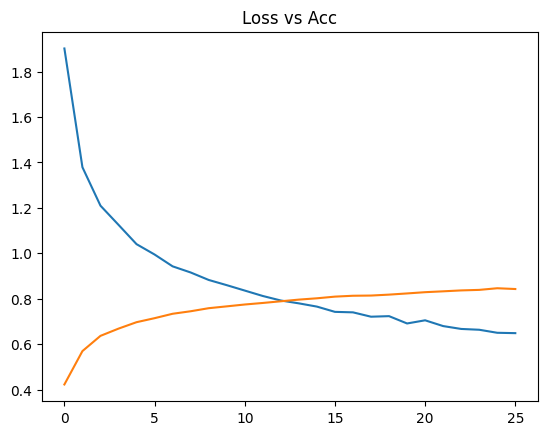

In [19]:
h = final.history
h.keys()



plt.plot(h['loss'])
plt.plot(h['accuracy'])

plt.title("Loss vs Acc")
plt.show()